In [74]:
import load_mnist_data

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
import torch.backends.cudnn as cudnn
import random
import os
import sys
from torch.autograd import Function

import matplotlib.pyplot as plt

In [64]:

class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None


class DANN(nn.Module):
    def __init__(self):
        super(DANN, self).__init__()
        self.feature = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=0),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.InstanceNorm2d(3),
            nn.Tanh()
        )
    
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
        )
        
    def forward(self, input_data, alpha):
            input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
            feature = self.feature(input_data)

            reconstructed_data = self.decoder(feature)
            feature = feature.view(-1, 512 * 2 * 2)
            reverse_feature = ReverseLayerF.apply(feature, alpha)
            class_output = self.classifier(feature)
            domain_output = self.domain_classifier(reverse_feature)

            return class_output, domain_output, reconstructed_data

In [87]:
def train(source, target, net, criterion,criterion_construct, optimizer, use_cuda, epoch):
    net.train() # Sets the module in training mode.
    total = 0
    batch_size = 128
    data_target_iter = iter(target)

    correct_source_label = 0
    correct_source_domain = 0
    correct_target_label = 0
    correct_target_domain = 0

    loss_min = 10000
    len_dataloader = min(len(source), len(target))

    for batch_idx, (source_inputs, source_label) in enumerate(source):
        batch_size = source_inputs.size(0)
        total += batch_size

        source_label = source_label.type(torch.LongTensor)
        domain_label = torch.zeros(batch_size).long()

        p = float(batch_idx + epoch * len_dataloader) / 50 / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        if use_cuda:
            source_inputs, source_label, domain_label = source_inputs.cuda(), source_label.cuda(), domain_label.cuda()

        optimizer.zero_grad()
        source_inputs, source_label = Variable(source_inputs), Variable(source_label)
        
        class_output, domain_output, reconstruct_source = net(input_data=source_inputs, alpha=alpha)

        _, predicted = torch.max(class_output.data, 1)
        correct_source_label += predicted.eq(source_label.data).cpu().sum().item()
        _, predicted = torch.max(domain_output.data, 1)
        correct_source_domain += predicted.eq(domain_label.data).cpu().sum().item()

        loss_s_label = criterion(class_output, source_label)
        loss_s_domain = criterion(domain_output, domain_label)
        loss_construct_ss = criterion_construct(reconstruct_source, source_inputs)
        
        target_inputs, target_label = data_target_iter.next()
        domain_label = torch.ones(batch_size).long()
        if use_cuda:
            target_inputs, target_label, domain_label = target_inputs.cuda(), target_label.cuda(), domain_label.cuda()
        
        class_output, domain_output, reconstruct_target = net(input_data=target_inputs, alpha=alpha)

        _, predicted = torch.max(class_output.data, 1)
        correct_target_label += predicted.eq(target_label.data).cpu().sum().item()
        _, predicted = torch.max(domain_output.data, 1)
        correct_target_domain += predicted.eq(domain_label.data).cpu().sum().item()

        loss_construct_tt = criterion_construct(reconstruct_target, target_inputs)
        loss_t_domain = criterion(domain_output, domain_label)

        loss = loss_s_label + loss_s_domain + loss_t_domain + loss_construct_tt + loss_construct_ss
        loss.backward()
        optimizer.step()

        if (loss < loss_min):
               loss_min = loss

               image_ss = reconstruct_source.data.cpu().detach().numpy()
               image_ts = reconstruct_target.data.cpu().detach().numpy()
               image_t =  target_inputs.data.cpu().detach().numpy()
               image_s =  source_inputs.data.cpu().detach().numpy()

    if (epoch % 5 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, correct_source_label/total, correct_source_domain/total, correct_target_label/total, correct_target_domain/total))

    return image_ss, image_ts, image_t, image_s





In [76]:
loader_source, loader_target = load_mnist_data.get_data_loader(1)

In [88]:
criterion = nn.CrossEntropyLoss()
criterion_construct = torch.nn.MSELoss()
net = DANN()
if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    net.cuda()
    criterion = criterion.cuda()
    criterion_construct = criterion_construct.cuda()
    
optimizer = optim.Adam(net.parameters(), lr=0.001) 


e: 0, sl: 0.769333, sd: 0.680333, tl: 0.420667, td: 0.654333
e: 5, sl: 0.960167, sd: 0.530667, tl: 0.484333, td: 0.489000
e: 10, sl: 0.984000, sd: 0.553000, tl: 0.480167, td: 0.505667
e: 15, sl: 0.989167, sd: 0.589000, tl: 0.509333, td: 0.528833
e: 20, sl: 0.986000, sd: 0.583167, tl: 0.517000, td: 0.542500
e: 25, sl: 0.988000, sd: 0.550167, tl: 0.514333, td: 0.551667
e: 30, sl: 0.989500, sd: 0.544833, tl: 0.519333, td: 0.530333
e: 35, sl: 0.985167, sd: 0.548833, tl: 0.518833, td: 0.548167
e: 40, sl: 0.993333, sd: 0.542833, tl: 0.518000, td: 0.521333
e: 45, sl: 0.991667, sd: 0.578500, tl: 0.534500, td: 0.554167
e: 50, sl: 0.993167, sd: 0.538667, tl: 0.552667, td: 0.524500


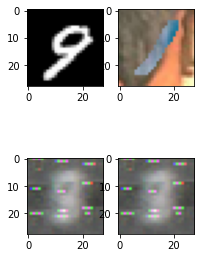

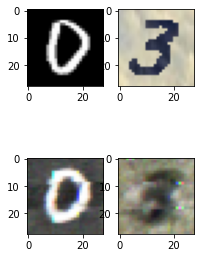

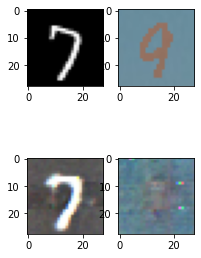

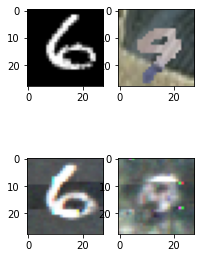

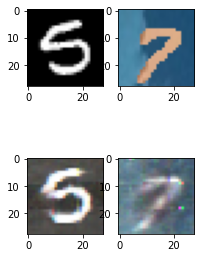

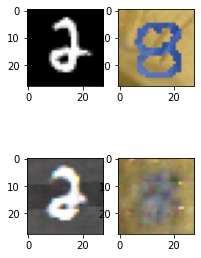

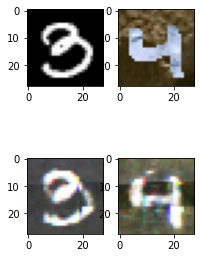

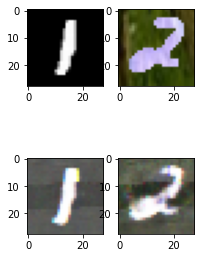

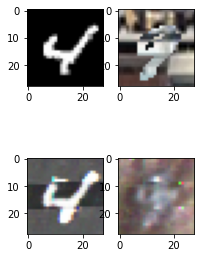

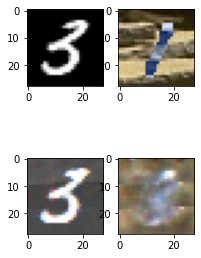

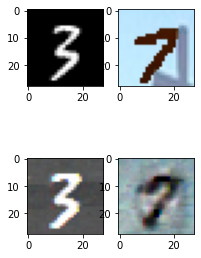

In [89]:
for epoch in range(0, 51):
    image_ss, image_ts, image_t, image_s = train(loader_source, loader_target, net, criterion, criterion_construct, optimizer, True, epoch) 
    index = 0
    if (epoch % 5 == 0):
        fig, axs = plt.subplots(nrows=2, ncols = 2, figsize=(3, 5))
        img = image_s[index].reshape(28,28,3)
        img = (img + 1) * 0.5

        img2 = image_t[index].reshape(28,28,3)
        img2 = (img2 + 1) * 0.5

        img3 = image_ss[index].reshape(28,28,3)
        img3 = (img3 + 1) * 0.5

        img4 = image_ts[index].reshape(28,28,3)
        img4 = (img4 + 1) * 0.5

        axs[0, 0].imshow(img)
        axs[0 ,1].imshow(img2)
        axs[1 ,0].imshow(img3)
        axs[1 ,1].imshow(img4)

        fig.savefig('./reconstruct/%d_img.png' % epoch)